In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

os.chdir(path="/root/py_projects/aihiii")

from src._StandardNames import StandardNames
from src.build.AnnUniversalImportableFTExtractor import AnnUniversal
from src.evaluate._Data import Data
import src.utils.json_util as json_util

STR: StandardNames = StandardNames()
PERC: int = 95

2024-09-09 14:42:00.213795: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/root/py_projects/aihiii/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
b_path = Path("models") / "CNN" / "Reference" / f"{PERC:02d}HIII_tg_injury_criteria"
d_path = Path("data") / "doe" / "doe_sobol_20240705_194200"
b_path.is_dir(), d_path.is_dir()

(True, True)

In [3]:
x, y = Data(), Data()
x.set_from_files(file_paths=[d_path / STR.fname_channels, d_path / STR.fname_injury_crit], percentiles=[50])
y.set_from_files(
    file_paths=[d_path / STR.fname_injury_crit],
    percentiles=[PERC],
    columns=[
        "Head_HIC15",
        "Head_a3ms",
        "Neck_My_Max",
        "Neck_Fz_Max_Tension",
        "Neck_Fx_Shear_Max",
        "Chest_Deflection",
        "Femur_Fz_Max_Compression",
    ],
)
idxs = x.get_tabular().index
drops = json_util.load(d_path / STR.fname_dropped_ids)
idxs = idxs.drop(drops[str(PERC)] + drops["50"])
x, y = Data(), Data()
x.set_from_files(file_paths=[d_path / STR.fname_channels, d_path / STR.fname_injury_crit], percentiles=[50], idxs=idxs)
y.set_from_files(
    file_paths=[d_path / STR.fname_injury_crit],
    percentiles=[PERC],
    columns=[
        "Head_HIC15",
        "Head_a3ms",
        "Neck_My_Max",
        "Neck_Fz_Max_Tension",
        "Neck_Fx_Shear_Max",
        "Chest_Deflection",
        "Femur_Fz_Max_Compression",
    ],
    idxs=idxs,
)

In [4]:
ann = AnnUniversal()
ann.load(model_dir=b_path, is_regression=True, is_multi_channel_regression=False, label_names=y.get_tabular().columns)

2024-09-09 14:42:37.788677: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-09 14:42:37.806849: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-09 14:42:37.807022: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-09 14:42:37.808987: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-09 14:42:37.809239: I external/local_xla/xla/stream_executor

In [5]:
y_pred = ann.predict(x=x)

I0000 00:00:1725892994.829288 3851635 service.cc:145] XLA service 0x7f1fec010000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725892994.829358 3851635 service.cc:153]   StreamExecutor device (0): Quadro P2000, Compute Capability 6.1
2024-09-09 14:43:14.863200: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-09 14:43:15.068604: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024-09-09 14:43:16.304508: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng13{} for conv (f32[32,100,1,180]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,43,1,180]{3,2,1,0}, f32[100,43,1,41]{3,2,1,0}, f32[100]{0}), window={size=1x41 pad=0_0x20_20}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on

  1/256 ━━━━━━━━━━━━━━━━━━━━ 49:34 12s/step

I0000 00:00:1725893005.994997 3851635 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


256/256 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step


In [6]:
y_pred.get_tabular().head()

,Chest_Deflection,Femur_Fz_Max_Compression,Head_HIC15,Head_a3ms,Neck_Fx_Shear_Max,Neck_Fz_Max_Tension,Neck_My_Max
ID,,,,,,,
0.0,38.066650,4.790253,131.504822,41.959480,1.028520,1.685683,37.374092
1.0,49.391590,6.065657,257.505249,54.059975,0.902862,1.396872,37.617722
2.0,41.983635,5.311357,171.400345,51.832031,0.952933,1.841654,39.975601
3.0,63.658325,7.457709,415.897247,66.242256,1.002367,1.528916,38.662075
4.0,64.794304,7.586370,448.958618,72.781326,1.232390,1.908433,51.503693


[None, None, None, None, None, None, None]

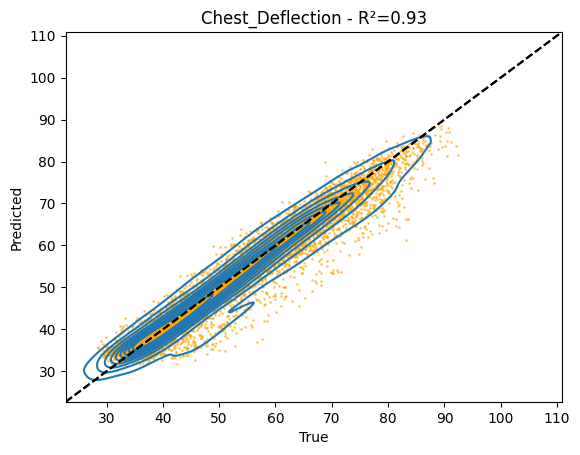

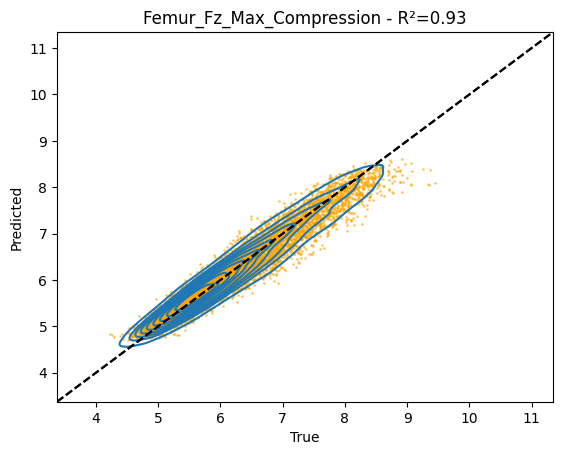

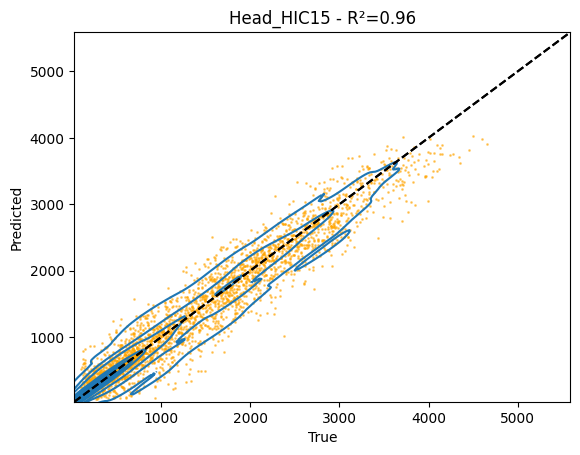

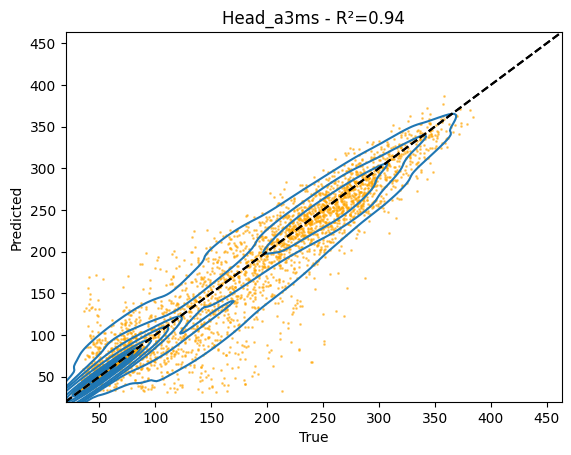

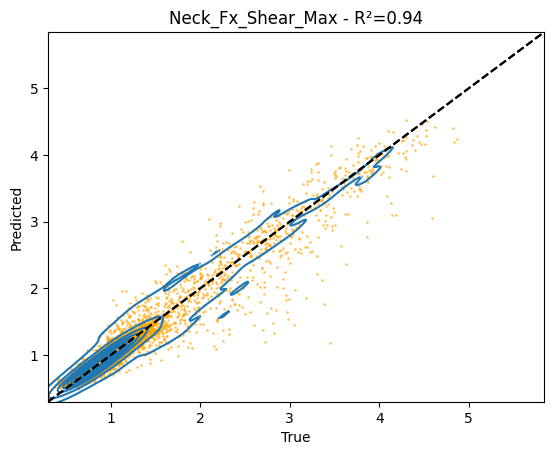

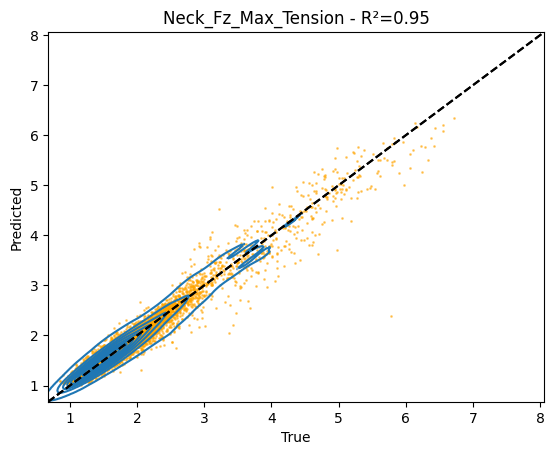

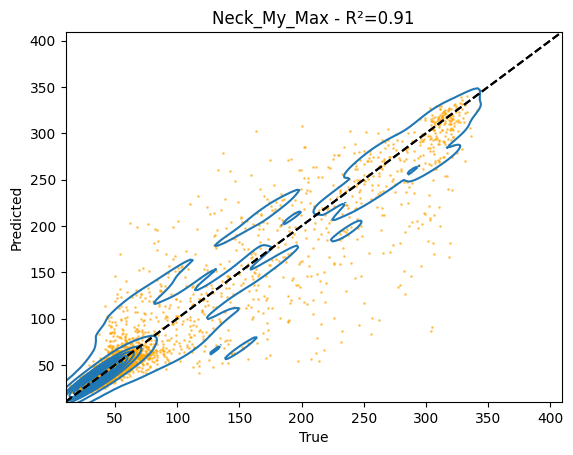

In [7]:
def plot(ch: str):
    fig, ax = plt.subplots()
    y_true = y.get_tabular()[ch]
    y_pred_ = y_pred.get_tabular()[ch]

    sns.kdeplot(x=y_true, y=y_pred_, ax=ax, fill=False, levels=10)
    ax.scatter(y_true, y_pred_, s=1, c="orange", alpha=0.5)

    r_spot = 0.8 * min([y_true.min(), y_pred_.min()])
    l_spot = 1.2 * max([y_true.max(), y_pred_.max()])
    ax.plot([r_spot, l_spot], [r_spot, l_spot], c="black", linestyle="--")
    ax.set_xlim([r_spot, l_spot])
    ax.set_ylim([r_spot, l_spot])
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, c="black", linestyle="--")

    ax.set_title(f"{ch} - R²={r2_score(y_true, y_pred_):.2f}")
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")


[plot(c) for c in sorted(y.get_tabular().columns)]